In [1]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

dataset_storage_directory = './mnist_dataset'
image_resolution = (28, 28)

mnist_dataset = datasets.MNIST(
    root=dataset_storage_directory,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_resolution),
        transforms.ToTensor()
    ]),
    download=True
)
from torch.utils.data import DataLoader

batch_size = 64
indices_of_digit_1 = [i for i, label in enumerate(mnist_dataset.targets) if label == 1]

# Create a subset of the dataset for digit '1' only
#mnist_dataset = Subset(mnist_dataset, indices_of_digit_1)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


In [33]:
import torch.nn as nn
import torch
# class SkipConnectionModule(nn.Module):
#   def __init__(self, layers) -> None:
#     super().__init__()
#     self.layers = layers
#   def forward(self, x):
#     initial_input = x
#     for layer in self.layers:
#       x = layer(x)
#     return x + initial_input
# Alternatively:
class DenseLayer(nn.Module):
  def __init__(self, input_channels, output_channels=12):
    super().__init__()
    self.layer = nn.Sequential(
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),
      nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
    )
  def forward(self, x):
    return self.layer(x)
class DenseConnectionModule(nn.Module):
  def __init__(self, input_channels, layer_count, growth_rate):
    super().__init__()
    self.layers = []
    channels = input_channels
    for i in range(layer_count):
      self.layers.append(DenseLayer(channels, growth_rate))
      channels += growth_rate
    self.layers = nn.ModuleList(self.layers)
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
class DenseConnectionModule(nn.Module):
  def __init__(self, layers: list) -> None:
    super().__init__()
    self.layers_array = layers
  def forward(self, x):
    residual_list = []
    for layer in self.layers_array:
      residual_list.append(x)
      x = torch.cat(residual_list, dim=1)
      x.shape
      x = layer(x)
    return torch.cat([*residual_list, x], dim=1)
    return x
class DenseNetModule(nn.Module):
  def __init__(self, input_channels=1, base_filter_dimension=32, output_dim=10):
    super().__init__()
    self.conv_layer_1 = nn.Conv2d(input_channels, 12, kernel_size=3, stride=1, padding=1)
    self.batch_norm_layer_1 = nn.BatchNorm2d(1)
    self.relu_1 = nn.ReLU()
    self.conv_layer_2 = nn.Conv2d(13, 12, kernel_size=3, stride=1, padding=1)
    self.batch_norm_layer_2 = nn.BatchNorm2d(13)
    self.relu_2 = nn.ReLU()
    self.conv_layer_3 = nn.Conv2d(25, 12, kernel_size=3, stride=1, padding=1)
    self.batch_norm_layer_3 = nn.BatchNorm2d(25)
    self.relu_3 = nn.ReLU()
    self.conv_layer_4 = nn.Conv2d(37, 12, kernel_size=3, stride=1, padding=1)
    self.batch_norm_layer_4 = nn.BatchNorm2d(37)
    self.relu_4 = nn.ReLU()
    self.global_average_pooling_layer = nn.AdaptiveAvgPool2d((1, 1))
    self.flattening_layer = nn.Flatten()
    self.final_fully_connected = nn.Linear(49, output_dim)
    self.dense_layer_1 = nn.Sequential(self.batch_norm_layer_1, self.relu_1, self.conv_layer_1)
    self.dense_layer_2 = nn.Sequential(self.batch_norm_layer_2, self.relu_2, self.conv_layer_2)
    self.dense_layer_3 = nn.Sequential(self.batch_norm_layer_3, self.relu_3, self.conv_layer_3)
    self.dense_layer_4 = nn.Sequential(self.batch_norm_layer_4, self.relu_4, self.conv_layer_4)
    self.dense_layer = DenseConnectionModule([self.dense_layer_1, self.dense_layer_2, self.dense_layer_3, self.dense_layer_4])
  def forward(self, x):
    x = self.dense_layer(x)
    x = self.global_average_pooling_layer(x)
    x = self.flattening_layer(x)
    return self.final_fully_connected(x)

In [28]:
from tqdm import tqdm
model = DenseNetModule()
EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
for epoch in range(0, 1):
  for image_batch, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
    image_batch = image_batch.to(device)
    model_output = model(image_batch)
    output = loss(model_output, labels.to(device))
    print(output)
    output.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch 1:   2%|▏         | 17/937 [00:00<00:11, 82.38it/s]

tensor(2.2745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2814, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2684, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2451, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2479, device='cuda:0', grad_fn=

Epoch 1:   4%|▎         | 35/937 [00:00<00:10, 85.09it/s]

tensor(2.2785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2318, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2246, device='cuda:0', grad_fn=

Epoch 1:   5%|▍         | 45/937 [00:00<00:10, 87.14it/s]

tensor(2.1994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1472, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1383, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1422, device='cuda:0', grad_fn=

Epoch 1:   7%|▋         | 64/937 [00:00<00:09, 87.71it/s]

tensor(2.0928, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1436, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0790, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9500, device='cuda:0', grad_fn=

Epoch 1:   9%|▉         | 83/937 [00:00<00:09, 86.49it/s]

tensor(2.0306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9446, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8353, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0182, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8917, device='cuda:0', grad_fn=

Epoch 1:  11%|█         | 102/937 [00:01<00:09, 89.12it/s]

tensor(1.8447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8159, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7849, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6960, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6943, device='cuda:0', grad_fn=

Epoch 1:  13%|█▎        | 121/937 [00:01<00:09, 90.23it/s]

tensor(1.7695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8216, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7639, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8219, device='cuda:0', grad_fn=

Epoch 1:  15%|█▌        | 141/937 [00:01<00:08, 89.36it/s]

tensor(1.7365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8814, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6220, device='cuda:0', grad_fn=

Epoch 1:  17%|█▋        | 159/937 [00:01<00:08, 87.96it/s]

tensor(1.6907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6341, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6990, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5629, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7646, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6856, device='cuda:0', grad_fn=

Epoch 1:  19%|█▉        | 177/937 [00:02<00:08, 86.59it/s]

tensor(1.7512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5528, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6200, device='cuda:0', grad_fn=

Epoch 1:  21%|██        | 195/937 [00:02<00:08, 86.25it/s]

tensor(1.4572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5810, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5860, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5329, device='cuda:0', grad_fn=

Epoch 1:  23%|██▎       | 214/937 [00:02<00:08, 87.69it/s]

tensor(1.6368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4430, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3511, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4921, device='cuda:0', grad_fn=

Epoch 1:  25%|██▍       | 233/937 [00:02<00:07, 88.28it/s]

tensor(1.5507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5764, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3832, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5337, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4349, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5566, device='cuda:0', grad_fn=

Epoch 1:  27%|██▋       | 251/937 [00:02<00:07, 88.35it/s]

tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5334, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3532, device='cuda:0', grad_fn=

Epoch 1:  29%|██▊       | 269/937 [00:03<00:08, 83.13it/s]

tensor(1.5300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3844, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3860, device='cuda:0', grad_fn=

Epoch 1:  31%|███       | 287/937 [00:03<00:07, 84.81it/s]

tensor(1.3943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5464, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4455, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3609, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4710, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5071, device='cuda:0', grad_fn=

Epoch 1:  33%|███▎      | 306/937 [00:03<00:07, 86.82it/s]

tensor(1.7629, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7440, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5894, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5320, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5892, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5332, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6214, device='cuda:0', grad_fn=

Epoch 1:  35%|███▍      | 324/937 [00:03<00:06, 87.81it/s]

tensor(1.4080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5712, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2569, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3478, device='cuda:0', grad_fn=

Epoch 1:  36%|███▋      | 342/937 [00:03<00:06, 87.20it/s]

tensor(1.3617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3411, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4621, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2571, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3566, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2609, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2964, device='cuda:0', grad_fn=

Epoch 1:  37%|███▋      | 351/937 [00:04<00:06, 84.93it/s]

tensor(1.3272, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2135, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3782, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3433, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 368/937 [00:04<00:08, 70.79it/s]

tensor(1.4337, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4935, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4062, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 384/937 [00:04<00:07, 69.61it/s]

tensor(1.3919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2894, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3866, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 400/937 [00:04<00:07, 69.47it/s]

tensor(1.1776, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2910, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3000, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3017, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 414/937 [00:05<00:07, 67.17it/s]

tensor(1.3257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5182, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3448, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 429/937 [00:05<00:07, 69.57it/s]

tensor(1.2027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4988, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1960, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 443/937 [00:05<00:07, 64.72it/s]

tensor(1.4256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1446, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2519, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6935, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3207, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 457/937 [00:05<00:07, 62.64it/s]

tensor(1.1778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1963, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2901, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3000, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2436, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2104, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 464/937 [00:05<00:07, 61.56it/s]

tensor(1.2922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5417, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3925, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 477/937 [00:06<00:08, 56.45it/s]

tensor(1.5019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3511, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1988, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 495/937 [00:06<00:06, 70.81it/s]

tensor(1.2200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3749, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3224, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2018, device='cuda:0', grad_fn=

Epoch 1:  55%|█████▍    | 514/937 [00:06<00:05, 79.85it/s]

tensor(1.2090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2336, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1330, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1747, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1652, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2283, device='cuda:0', grad_fn=

Epoch 1:  57%|█████▋    | 532/937 [00:06<00:04, 82.81it/s]

tensor(1.0449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3406, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2569, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2387, device='cuda:0', grad_fn=

Epoch 1:  59%|█████▊    | 550/937 [00:06<00:04, 85.46it/s]

tensor(1.1678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2553, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1764, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1370, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1980, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3642, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3999, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0613, device='cuda:0', grad_fn=

Epoch 1:  61%|██████    | 568/937 [00:07<00:04, 83.83it/s]

tensor(1.1578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3689, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3632, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0122, device='cuda:0', grad_fn=

Epoch 1:  63%|██████▎   | 586/937 [00:07<00:04, 85.97it/s]

tensor(1.2214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1393, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0865, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0350, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4651, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0183, device='cuda:0', grad_fn=

Epoch 1:  64%|██████▍   | 604/937 [00:07<00:03, 87.56it/s]

tensor(1.1501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1853, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1416, device='cuda:0', grad_fn=

Epoch 1:  66%|██████▋   | 623/937 [00:07<00:03, 88.33it/s]

tensor(1.1926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9845, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2849, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1456, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1798, device='cuda:0', grad_fn=

Epoch 1:  68%|██████▊   | 641/937 [00:07<00:03, 86.20it/s]

tensor(1.0603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0446, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9253, device='cuda:0', grad_fn=

Epoch 1:  70%|███████   | 659/937 [00:08<00:03, 84.63it/s]

tensor(1.1273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2398, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0314, device='cuda:0', grad_fn=

Epoch 1:  72%|███████▏  | 677/937 [00:08<00:03, 85.74it/s]

tensor(0.9917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1277, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9166, device='cuda:0', grad_fn=

Epoch 1:  74%|███████▍  | 695/937 [00:08<00:02, 86.41it/s]

tensor(1.0707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0712, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0847, device='cuda:0', grad_fn=

Epoch 1:  76%|███████▌  | 714/937 [00:08<00:02, 87.12it/s]

tensor(1.0906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1588, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0520, device='cuda:0', grad_fn=

Epoch 1:  78%|███████▊  | 733/937 [00:09<00:02, 88.52it/s]

tensor(1.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0274, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3475, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0621, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0365, device='cuda:0', grad_fn=

Epoch 1:  80%|████████  | 752/937 [00:09<00:02, 86.73it/s]

tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9971, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8412, device='cuda:0', grad_fn=

Epoch 1:  82%|████████▏ | 771/937 [00:09<00:01, 88.32it/s]

tensor(1.1008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0464, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1724, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0036, device='cuda:0', grad_fn=

Epoch 1:  84%|████████▍ | 789/937 [00:09<00:01, 88.28it/s]

tensor(0.8760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0342, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1164, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0615, device='cuda:0', grad_fn=

Epoch 1:  86%|████████▌ | 807/937 [00:09<00:01, 88.44it/s]

tensor(0.9284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0224, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2519, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1830, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1534, device='cuda:0', grad_fn=

Epoch 1:  87%|████████▋ | 816/937 [00:09<00:01, 85.88it/s]

tensor(1.0532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8814, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8274, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9885, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0855, device='cuda:0', grad_fn=

Epoch 1:  89%|████████▉ | 834/937 [00:10<00:01, 83.02it/s]

tensor(0.9706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7720, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0582, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9348, device='cuda:0', grad_fn=

Epoch 1:  91%|█████████ | 852/937 [00:10<00:00, 85.18it/s]

tensor(0.9280, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9928, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9421, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1387, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8804, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9944, device='cuda:0', grad_fn=

Epoch 1:  93%|█████████▎| 870/937 [00:10<00:00, 86.13it/s]

tensor(1.0282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0732, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0592, device='cuda:0', grad_fn=

Epoch 1:  95%|█████████▍| 888/937 [00:10<00:00, 85.00it/s]

tensor(0.8976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9950, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7591, device='cuda:0', grad_fn=

Epoch 1:  97%|█████████▋| 906/937 [00:11<00:00, 83.34it/s]

tensor(0.8433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9566, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8549, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6834, device='cuda:0', grad_fn=

Epoch 1:  99%|█████████▊| 924/937 [00:11<00:00, 83.52it/s]

tensor(0.9638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9511, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7796, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7988, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9258, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7542, device='cuda:0', grad_fn=

Epoch 1: 100%|██████████| 937/937 [00:11<00:00, 82.12it/s]

tensor(1.2319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0264, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9607, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor([-2.0615, -2.3320,  0.8131, -0.8224,  1.4150,  0.1474,  0.0637,  1.2699,
        -1.0131,  2.1657], device='cuda:0', grad_fn=<SelectBackward0>)


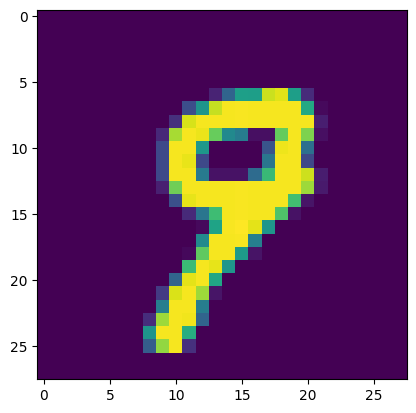

In [32]:
import matplotlib.pyplot as plt
plt.imshow(image_batch.cpu()[3][0])
print(model(image_batch)[3])